In [1]:
import torch
import torch.nn as nn
import torchvision

# %matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt

import time
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from dataset import *
from transforms import *
from criteria import *
from torch.utils.data import DataLoader, random_split

torch.manual_seed(42)

In [ ]:
# BSDS 500

# NOTE: remember to adjust PadTo2Power's k value according to gamma-net depth
# NOTE: data stays in CPU until right before forward pass (i.e. no need for memory pinning, etc)

x_transform = torchvision.transforms.Compose([CenterCrop((256,256)),
                                              ToTensor(make_channel_first=True, div=True),
                                              PadTo2Power(axes=(1,2), k=5, mode='constant'),
                                              AssertWidthMajor()])
y_transform = torchvision.transforms.Compose([CenterCrop((256,256)),
                                              ToTensor(make_channel_first=False, float_out=False),
                                              PadTo2Power(axes=(0,1), k=5, mode='constant'),
                                              AssertWidthMajor()])
ds_train = SimpleDataset("bsds500/x_train.txt",
                         "bsds500/y_c_train.txt",
                         x_transform=x_transform, y_transform=y_transform)
dl_train = DataLoader(ds_train, batch_size=4, shuffle=True, num_workers=0)

In [94]:
# ACDC

# NOTE: remember to adjust PadTo2Power's k value according to gamma-net depth
# NOTE: data stays in CPU until right before forward pass (i.e. no need for memory pinning, etc)

val_ratio = 0.2

x_transform = torchvision.transforms.Compose([GaussianSmooth(3,1),
                                              CLAHE(clipLimit=2.0, tileGridSize=(8,8)),
                                              lambda x: (x-x.min()) / (x.max()-x.min()),
                                              PadOrCenterCrop(size=(224,224)),
                                              ToTensor(make_channel_first=True, div=False),
                                              ExpandDims(dim=0)])
y_transform = torchvision.transforms.Compose([PadOrCenterCrop(size=(224,224)),
                                              ToTensor(make_channel_first=False, float_out=False),
                                              SelectClass(3)])
ds = SimpleDataset("ACDC_Dataset_p/training/x_arr.txt", "ACDC_Dataset_p/training/y_arr.txt",
                   x_transform=x_transform, y_transform=y_transform, use_cache=True)
ds_train, ds_val = random_split(ds, [len(ds) - int(len(ds)*val_ratio), int(len(ds)*val_ratio)])
dl_train = DataLoader(ds_train, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
dl_val = DataLoader(ds_val, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)

In [90]:
# sunnybrook

x_transform = torchvision.transforms.Compose([lambda x: x.squeeze(),
#                                               lambda x: ((x-x.mean()) / x.std()),
                                              lambda x: (x-x.min()) / (x.max()-x.min()),
#                                               GaussianSmooth(3,1),
#                                               CLAHE(clipLimit=0.8, tileGridSize=(8,8)),
                                              PadOrCenterCrop(size=(192,192)),
                                              ToTensor(make_channel_first=True, div=False),
                                              ExpandDims(dim=0)])
y_transform = torchvision.transforms.Compose([lambda y:y.squeeze(),
                                              PadOrCenterCrop(size=(192,192)),
                                              ToTensor(make_channel_first=False, float_out=False)])
ds_val = SimpleDataset("sunnybrook_180/val/images.npy", "sunnybrook_180/val/masks.npy", 
                       x_transform=x_transform, y_transform=y_transform, use_cache=False)
dl_val = DataLoader(ds_val, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)

# U-Net

In [3]:
from pytorch_unet.unet import UNet

model = UNet(in_channels=1, n_classes=2, depth=5, wf=3,
        padding=True, batch_norm=True, up_mode='upsample')

if torch.cuda.is_available():
    model = model.cuda().float()
else:
    model = model.double()

In [4]:
load_model = True
model_file = "models_unet_2/model_unet_e200.pkl"
if load_model:
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(model_file))
    else:
        model.load_state_dict(torch.load(model_file, map_location=torch.device('cpu')))

In [5]:
unet = nn.DataParallel(model)

# Gamma-Net

In [6]:
from gammanet import GammaNet

gammanet_config = {
    'in_channels': 1,
    'return_sequences': False,
    'num_filters': [24, 28, 32, 48, 64],
    'conv_kernel_size': [3, 3, 3, 3, 3],
    'conv_blocksize': [1, 1, 1, 1, 1],
    'conv_normtype': 'instancenorm',
    'conv_dropout_p': 0.2,  # 0.2
    'conv_residual': False,
    'fgru_hidden_size': [24, 28, 32, 48, 64],
    'fgru_kernel_size': [9,  7,  5,  3,  1,  1,  1,  1,  1],
    'fgru_timesteps': 4,
    'fgru_normtype': 'instancenorm',
    'fgru_channel_sym': True,
    'fgru_attention_args': {
                "type": "gala",
                "filters": 5,
                "layers": 1
            },
    'upsample_mode': 'bilinear',
    'upsample_all2all': True,
}

model = nn.Sequential(
#     nn.Conv2d(1, 24, 3, padding=1), # Change the number of input channels! 
#     nn.Conv2d(24, 24, 3, padding=1),
    GammaNet(gammanet_config),
    nn.Conv2d(24, 2, 5, padding=2),  # Change the expected number of output classes! 
    nn.Conv2d(2, 2, 1, padding=0)
)

if torch.cuda.is_available():
    model = model.cuda().float()
else:
    model = model.double()

In [7]:
load_model = True
model_file = "model_e150.pkl"
if load_model:
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(model_file))
    else:
        model.load_state_dict(torch.load(model_file, map_location=torch.device('cpu')))

In [8]:
gnet = nn.DataParallel(model)

# Tests

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(unet.module))
print(count_parameters(gnet.module))

454514
481351


## Dice

In [95]:
dice_unet = 0
dice_gnet = 0
for i, (x,y) in enumerate(dl_val):
    print("{}/{}".format(i,len(dl_val)), end='\r')
    with torch.no_grad():
        res_unet = unet(x.float())
        res_gnet = gnet(x.float())
#         res_unet = torch.sigmoid(res_unet)
#         res_gnet = torch.sigmoid(res_gnet)
        dice_unet += dice_coeff_mc(res_unet.cpu(), y)
        dice_gnet += dice_coeff_mc(res_gnet.cpu(), y)
print(dice_unet/len(dl_val), dice_gnet/len(dl_val))

tensor(0.8835) tensor(0.9755)


## Result visualizations

In [85]:
# load from val data

x,y = next(iter(dl_val))
x = x.float() if torch.cuda.is_available() else x.double()
print(x.shape, y.shape)
print(x.max(),x.min(),y.max(),y.min())

torch.Size([8, 1, 192, 192]) torch.Size([8, 192, 192])
tensor(1.) tensor(0.) tensor(1) tensor(0)


In [86]:
# run test data through model

model = unet
model.eval()
with torch.no_grad():
    res_unet = model(x)
    print(dice_coeff_mc(F.sigmoid(res_unet).cpu(),y,drop_neg_label=True))
    print(nn.CrossEntropyLoss()(res_unet.cpu(),y.long()))

tensor(0.0002)
tensor(1.0707)


In [87]:
# run test data through model

model = gnet
model.eval()
with torch.no_grad():
    res_gnet = 1-model(x)
    print(dice_coeff_mc(F.sigmoid(res_gnet).cpu(),y,drop_neg_label=True))
    print(nn.CrossEntropyLoss()(res_gnet.cpu(),y.long()))

tensor(0.8007)
tensor(33.5346)


0


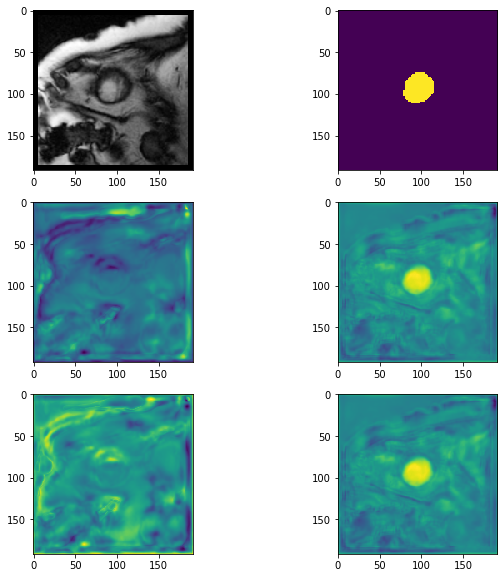

1


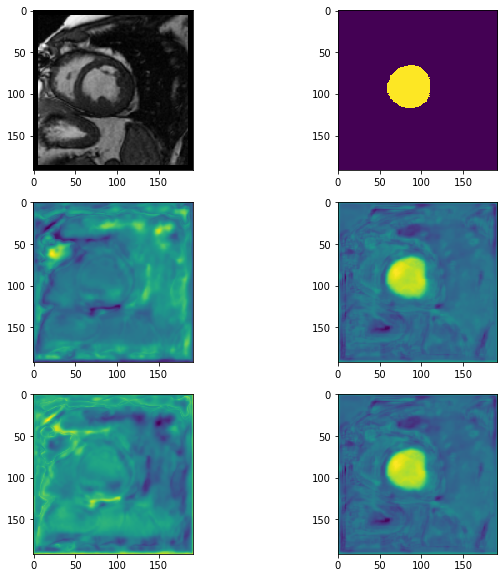

2


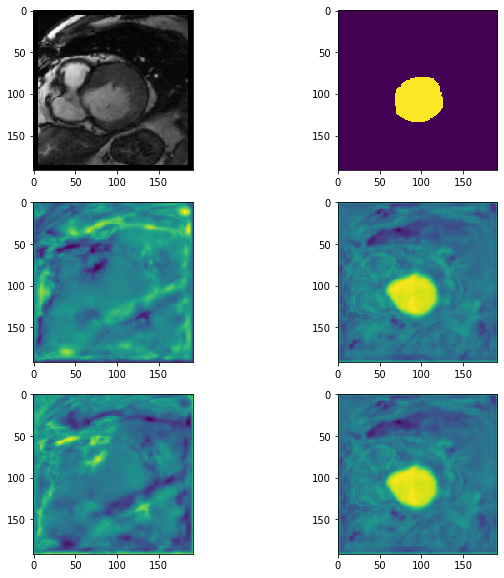

3


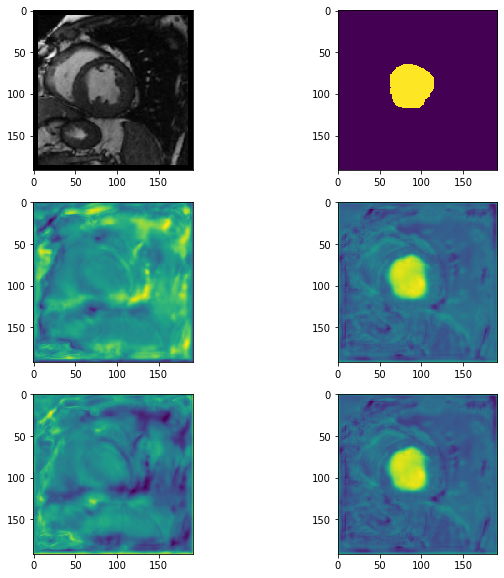

4


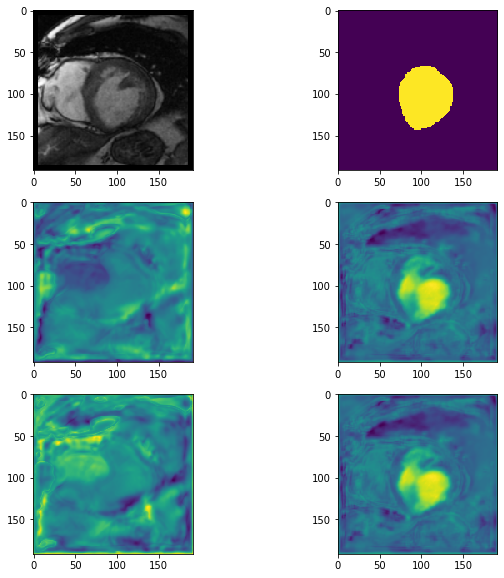

5


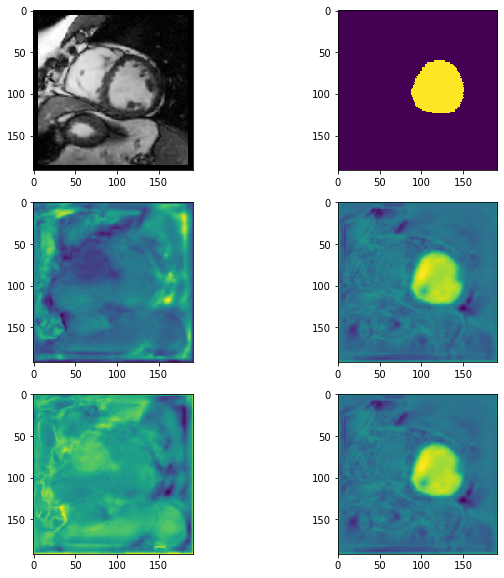

6


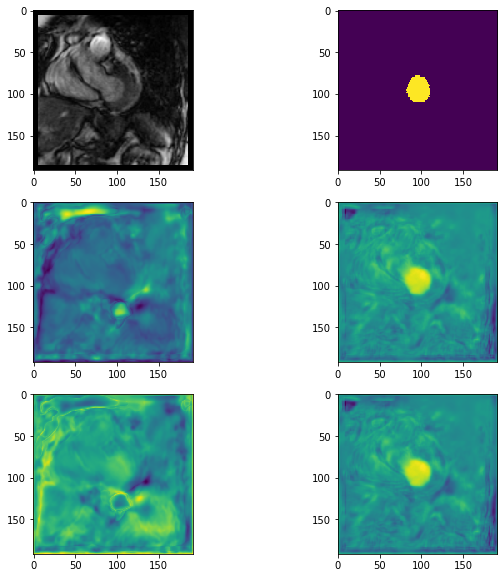

7


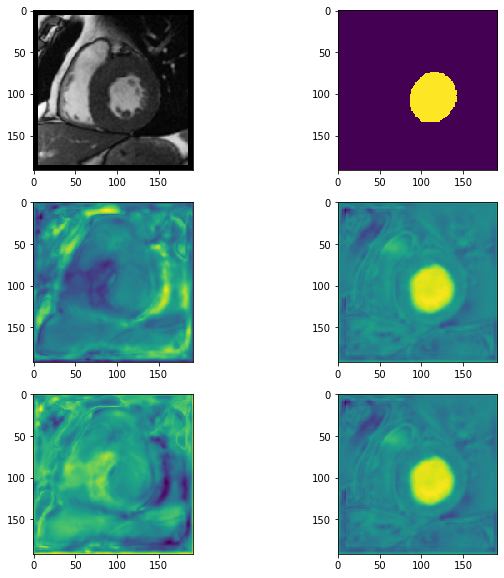

In [88]:
# visualize ACDC results
thres = 0.
num_classes = 2

for i in range(x.shape[0]):
    print(i)
    plt.figure(figsize=(10,10))
    plt.subplot(num_classes+1,2,1)
    plt.imshow(x[i].numpy()[0], cmap='gray')
    if "y" in dir():
        plt.subplot(num_classes+1,2,2)
        plt.imshow(y[i])
    for j in range(num_classes):
        plt.subplot(num_classes+1,2,2+2*j+1)
        plt.imshow((res_unet).cpu().detach().numpy()[i,j])
        plt.subplot(num_classes+1,2,2+2*j+2)
        plt.imshow((res_gnet).cpu().detach().numpy()[i,j])
#         plt.colorbar()
    plt.show()

## Result visualization per timestep

In [ ]:
# request gammanet to return sequence

m = model.module
m[2].config['return_sequences'] = True

In [ ]:
# get returned sequences from gammanet 

out = m[0](x)
out = m[1](out)
out = m[2](out)

In [ ]:
# visualize  per-timestep outputs

idx = 3
label = 1

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(x[idx].cpu().detach().numpy()[0], cmap='gray')
if "y" in dir():
    plt.subplot(1,2,2)
    plt.imshow(y[idx])
plt.show()

plt.figure(figsize=(20,20))
for i, o in enumerate(out[1]):
    o = m[3](o)
    plt.subplot(len(out[1])//4+1, 4, i+1)
    plt.imshow(o[idx,label].cpu().detach().numpy())
plt.show()

In [ ]:
del(out)

## fGRU kernel visualization

In [ ]:
# inhibition kernels in first down block fGRU
k = model.module.state_dict()['2.fgru_down.0.params.w_inh']
for i in range(k.shape[0]):
    print(i)
    plt.figure(figsize=(15,10))
    for j in range(k.shape[1]):
        plt.subplot(4,6,j+1)
        plt.imshow(k.cpu().detach().numpy()[i,j])
    plt.show()

In [ ]:
# excitation kernels in first down block fGRU
k = model.module.state_dict()['2.fgru_down.0.params.w_exc']
for i in range(k.shape[0]):
    print(i)
    plt.figure(figsize=(15,10))
    for j in range(k.shape[1]):
        plt.subplot(4,6,j+1)
        plt.imshow(k.cpu().detach().numpy()[i,j])
    plt.show()

In [ ]:
k = model.module.state_dict()['2.fgru_down.1.params.w_inh']
plt.figure(figsize=(15,10))
for i in range(k.shape[0]):
    plt.subplot(4,7,i+1)
    plt.imshow(k.cpu().detach().numpy()[0,i])
plt.show()

In [ ]:
k = model.module.state_dict()['2.fgru_down.1.params.w_exc']
plt.figure(figsize=(15,10))
for i in range(k.shape[0]):
    plt.subplot(4,7,i+1)
    plt.imshow(k.cpu().detach().numpy()[0,i])
plt.show()